In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


In [15]:
import os
import numpy as np
import tensorflow as tf

In [16]:
# img = tf.keras.utils.load_img('../keepfit/carbonara/000a5631ae0322940c2dba4458104f73c35a2c8a80c81a8a05ae2215deae9d9b.jpeg')
# img

In [17]:
# filepath = '../keepfit/carbonara/000a5631ae0322940c2dba4458104f73c35a2c8a80c81a8a05ae2215deae9d9b.jpeg'
# img = tf.keras.utils.load_img(filepath)
# x = tf.keras.utils.img_to_array(img)
# print('input shape:',x.shape)
# print('input sample:',x[0][0])

In [18]:
# x = tf.cast(x, tf.float32)
# x = x/127.5
# x = x-1

In [19]:
import cv2
import os

parentPath = '../keepfit/training-img-dataset/'
# class_labels = 'burgers'

# path = os.path.join(parentPath, class_labels)

# for file in os.listdir(path):
#     photo = os.path.join(path, file)
#     im = cv2.imread(photo)
#     h, w , c = im.shape
#     print('w', w, 'h',h, c)

# im = cv2.imread('../keepfit/carbonara/000a5631ae0322940c2dba4458104f73c35a2c8a80c81a8a05ae2215deae9d9b.jpeg')
# h, w, c = im.shape
# print('width', w)
# print('height', h)
# print('channgel', c)

In [20]:
width = 259
height = 194

image_size = (width, height)
image_shape = (width, height, 3)

In [21]:
class_labels = ['alldaybreakfast', 'burgers', 'caesar', 'carbonara', 'risotto', 'steak']

def load_dataset(dataset_dir = "../keepfit/training-img-dataset", sample_size = None):
    images = []
    labels = [] 
    
    for class_label in os.listdir(dataset_dir):
        if class_label in class_labels:
            class_index = class_labels.index(class_label)
            print('loading images of label:', class_label)
            class_dir = os.path.join(dataset_dir, class_label)
            samples = 0 
            for filename in os.listdir(class_dir):
                # print('filename:', filename)
                if not filename.endswith('.jpeg'):
                    continue
                if sample_size != None and samples >= sample_size:
                    break
                filepath = os.path.join(class_dir, filename)
                img = tf.keras.utils.load_img(filepath, target_size=image_size)
                x = tf.keras.utils.img_to_array(img)
                x = tf.cast(x, tf.float32)
                x = x / 127.5
                x = x - 1
                images.append(x)
                labels.append(float(class_index))
                samples = samples + 1
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)
    return dataset

sample_size = 300
train_dataset = load_dataset(sample_size=sample_size, dataset_dir='../keepfit/training-img-dataset')
test_dataset = load_dataset(sample_size=sample_size, dataset_dir='../keepfit/testing-img-dataset')

loading images of label: steak


2023-09-14 19:18:28.175365: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-09-14 19:18:28.175387: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-14 19:18:28.175390: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-14 19:18:28.175546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-14 19:18:28.175562: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


loading images of label: burgers
loading images of label: caesar
loading images of label: carbonara
loading images of label: risotto
loading images of label: alldaybreakfast
loading images of label: steak
loading images of label: burgers
loading images of label: caesar
loading images of label: carbonara
loading images of label: risotto
loading images of label: alldaybreakfast


In [22]:
print("train dataset", train_dataset)
print("test dataset", test_dataset)

train dataset <_ShuffleDataset element_spec=(TensorSpec(shape=(259, 194, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
test dataset <_ShuffleDataset element_spec=(TensorSpec(shape=(259, 194, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [23]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))

train_slices = train_dataset.take(train_size)
validation_slices = train_dataset.skip(train_size)

print(len(train_slices))
print(len(validation_slices))

1277
142


In [24]:
batch_size = 32 

train_slices = train_slices.batch(batch_size)
validation_slices = validation_slices.batch(batch_size)
test_slices = test_dataset.batch(batch_size)

In [25]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=image_shape,
  include_top=False,
  weights='imagenet'
)

In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 259, 194, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 130, 97, 32)          864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 130, 97, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 130, 97, 32)          0         ['bn_Conv1[

In [27]:
base_model.trainable = False

In [28]:
image_sample, label_sample = next(iter(train_slices.take(1)))
feature_sample = base_model(image_sample)
print("shape", feature_sample.shape)
feature_sample

shape (32, 9, 7, 1280)


<tf.Tensor: shape=(32, 9, 7, 1280), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.      

In [29]:
base_model_feature_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
base_model_feature_pooling_layer.shape

TensorShape([None, 1280])

In [30]:
prediction_layer = tf.keras.layers.Dense(1)(base_model_feature_pooling_layer)
prediction_layer.shape

TensorShape([None, 1])

In [31]:
food_model = tf.keras.Model(
  inputs=base_model.input,
  outputs=prediction_layer
)

food_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 259, 194, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 130, 97, 32)          864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 130, 97, 32)          128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 130, 97, 32)          0         ['bn_Conv1[0][0]']        

In [37]:
learning_rate = 0.03

food_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate),
  # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [38]:
epochs = 20
validation_steps = 5

loss, accuracy = food_model.evaluate(validation_slices, steps=validation_steps)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

2023-09-14 19:30:08.692027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 8s 499ms/step - loss: 0.0000e+00 - accuracy: 0.1761
initial loss: 0.00
initial accuracy: 0.18


In [39]:
from tensorflow import keras

loss_history = []
accuracy_history = []

class PerMatchMetrics(keras.callbacks.Callback):
  def on_train_batch_end(self, batch, logs=None):
    loss_history.append(logs['loss'])
    accuracy_history.append(logs['accuracy'])

history = food_model.fit(
  train_slices,
  epochs=epochs,
  validation_data=validation_slices,
  callbacks=[PerMatchMetrics()]
)

Epoch 1/20


2023-09-14 19:30:17.049841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 9s 165ms/step - loss: 0.0000e+00 - accuracy: 0.1457 - val_loss: 0.0000e+00 - val_accuracy: 0.1620
Epoch 2/20
40/40 [==============================] - 5s 119ms/step - loss: 0.0000e+00 - accuracy: 0.1464 - val_loss: 0.0000e+00 - val_accuracy: 0.1408
Epoch 3/20
40/40 [==============================] - 5s 116ms/step - loss: 0.0000e+00 - accuracy: 0.1504 - val_loss: 0.0000e+00 - val_accuracy: 0.1549
Epoch 4/20
40/40 [==============================] - 5s 129ms/step - loss: 0.0000e+00 - accuracy: 0.1496 - val_loss: 0.0000e+00 - val_accuracy: 0.1408
Epoch 5/20
40/40 [==============================] - 5s 115ms/step - loss: 0.0000e+00 - accuracy: 0.1417 - val_loss: 0.0000e+00 - val_accuracy: 0.1197
Epoch 6/20
40/40 [==============================] - 5s 111ms/step - loss: 0.0000e+00 - accuracy: 0.1488 - val_loss: 0.0000e+00 - val_accuracy: 0.1127
Epoch 7/20
40/40 [==============================] - 4s 108ms/step - loss: 0.0000e+00 - accuracy: 0.1410 - val_l

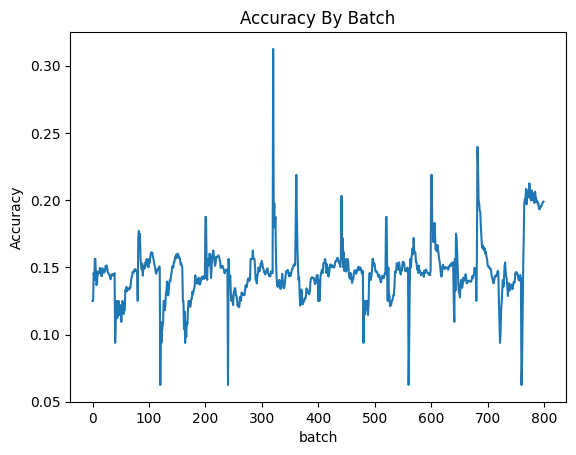

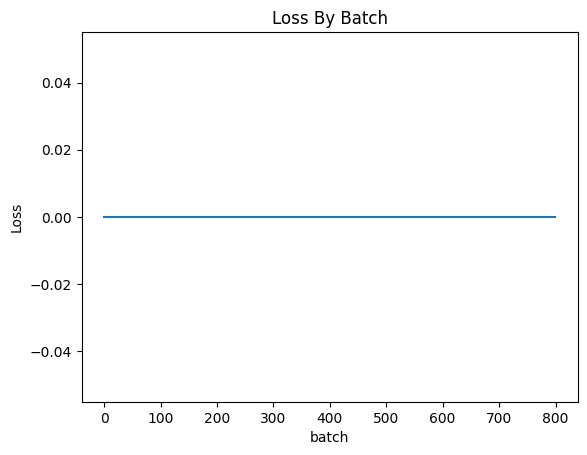

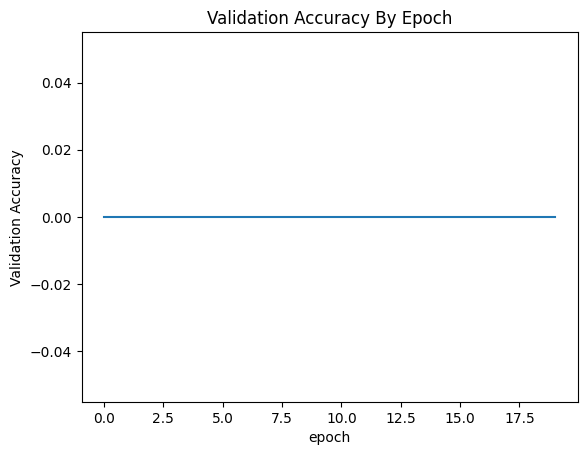

In [40]:
import matplotlib.pyplot as plt

plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('batch')
plt.ylabel('Accuracy')
plt.title('Accuracy By Batch')
plt.show()

plt.plot(loss_history, label='Loss')
plt.xlabel('batch')
plt.ylabel('Loss')
plt.title('Loss By Batch')
plt.show()

plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy By Epoch')
plt.show()

In [41]:
food_model.save("./models/animal_model", overwrite=True)

INFO:tensorflow:Assets written to: ./models/animal_model/assets


INFO:tensorflow:Assets written to: ./models/animal_model/assets
